# Bearings dataset EDA

In this note book I investigate dataset charachtristics in the dataset. This is the 2nd step in CRISP-DM, "data understanding" and helps in model selection and analysis

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
data01_path = './Datasets/bearings01/NB.csv'
data02_path = './Datasets/bearings01/IR - 7.csv'
data03_path = './Datasets/bearings01/IR - 21.csv'
data04_path = './Datasets/bearings01/OR - 7.csv'
data05_path = './Datasets/bearings01/OR - 21.csv'

it's better to preprocess datasets separately. This can help us understand each one better, prevent data leakage which may happen during normalization or standardization, and also prevents domminance of one or more datasets during scaling.

## normal signal

In [3]:
df_normal = pd.read_csv(data01_path)
df_normal.head()

,DE,FE
0,0.064254,0.038625
1,0.063002,0.096769
2,-0.004381,0.127382
3,-0.035882,0.144640
4,-0.023991,0.086702


In [4]:
signal_columns = {'DriveEndAcc', 'FanEndAcc'}
df_normal.columns = signal_columns
# since we have two classes we can use 1 for faulti and -1 for normal labels and still prevent ordinal label bias.
# however, one-hot-encoding is also an option which is usually used for more classes
df_normal['fault'] = 0

### check stats and nulls

In [5]:
print(df_normal.info())
print(df_normal.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121155 entries, 0 to 121154
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   FanEndAcc    121155 non-null  float64
 1   DriveEndAcc  121155 non-null  float64
 2   fault        121155 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.8 MB
None
           FanEndAcc    DriveEndAcc     fault
count  121155.000000  121155.000000  121155.0
mean        0.011768       0.032724       0.0
std         0.063400       0.065195       0.0
min        -0.275998      -0.213056       0.0
25%        -0.030249      -0.013355       0.0
50%         0.014186       0.031024       0.0
75%         0.056118       0.077045       0.0
max         0.359236       0.303867       0.0


### check duplicates

**Should I Remove Duplicates in an Accelerometer-Based Bearing Fault Dataset?**

***How Do Duplicates Arise?***

*Steady-state signals:* If the system operates under stable conditions, some measurements might appear identical across consecutive timestamps.

*Sensor precision limits:* If sensor resolution is limited, small changes might be rounded, leading to identical readings.

*Sampling effects:* Data might be sampled at a high rate, leading to near-identical readings due to minimal change in vibration levels.

*Data preprocessing issues:* If data has been preprocessed (e.g., resampled, interpolated, or aggregated), duplicates might appear.

***Does Removing Duplicates Affect Fault Detection?***

If the dataset is showing a trend, removing duplicates could be a bad move because:

*Fault evolution might be gradual:* Removing duplicates could eliminate important information about how a fault develops over time.

*Temporal relationships matter:* Vibration patterns in bearings often involve subtle changes over time, which duplicates may represent.

*Pattern recognition models rely on time-series data:* If you plan to use Machine Learning (e.g., CNNs, LSTMs), removing duplicates could disrupt meaningful patterns.


However, if duplicates do not provide new information (e.g., they arise from artifacts of data collection), then removing them might help reduce data size without losing useful signals.

In [6]:
print('number of duplicates in the dataset: ', sum(df_normal.duplicated()))

number of duplicates in the dataset:  6519


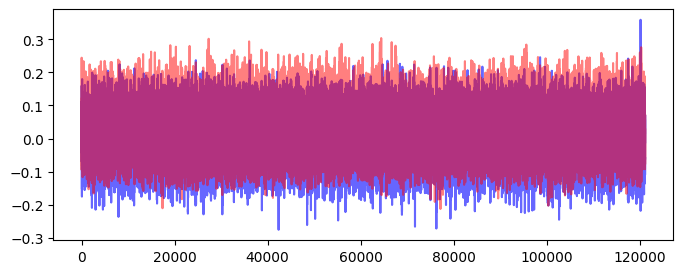

In [16]:
plt.figure(figsize = (8,3))
plt.plot(df_normal.index, df_normal.iloc[:,0], color='blue', alpha=0.6)#DriveEnd Acc. is Blue
plt.plot(df_normal.index, df_normal.iloc[:,1], color='red', alpha=0.5)#FanEnd Acc. is red
plt.show()


instead of removing duplicates lets first understand the duplication pattern and find the possible reason for that.
first I create a column that marks all duplicates. Then a column that marks duplicates by grouping them. In this way I can plot duplicates related to each group and compare them with the data pattern.

In [42]:
df_normal['duplicated'] = np.where(df_normal.duplicated(subset=signal_columns,keep=False), 1, 0)
df_normal['duplicate_group'] = df_normal[df_normal['duplicated']==1].groupby(['DriveEndAcc', 'FanEndAcc']).ngroup()+1
df_normal['duplicate_group'] = df_normal['duplicate_group'].fillna(0)
df_normal.describe()

,FanEndAcc,DriveEndAcc,fault,duplicated,duplicate_group
count,121155.000000,121155.000000,121155.0,121155.000000,121155.000000
mean,0.011768,0.032724,0.0,0.104915,324.623218
std,0.063400,0.065195,0.0,0.306445,1110.240597
min,-0.275998,-0.213056,0.0,0.000000,0.000000
25%,-0.030249,-0.013355,0.0,0.000000,0.000000
50%,0.014186,0.031024,0.0,0.000000,0.000000
75%,0.056118,0.077045,0.0,0.000000,0.000000
max,0.359236,0.303867,0.0,1.000000,6192.000000


While the numbe rof duplicares is 6519 and th enumber of duplicate groups is 6192, 327 have more than two repeatitions.


In [43]:
df_normal_filtered = df_normal[df_normal['duplicated']==1]
df_normal_filtered.head()

,FanEndAcc,DriveEndAcc,fault,duplicated,duplicate_group
6,0.030249,-0.038625,0,1,582.0
21,-0.010639,0.077045,0,1,5215.0
38,-0.005841,0.170322,0,1,6182.0
47,0.028163,0.081360,0,1,5342.0
51,0.011474,-0.049925,0,1,355.0


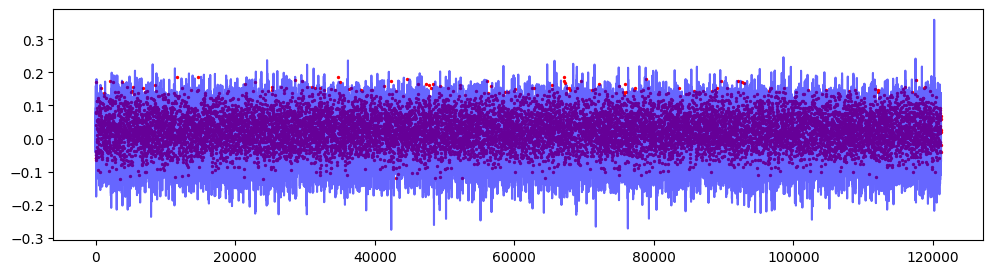

In [60]:
plt.figure(figsize = (12,3))
plt.plot(df_normal.index, df_normal.iloc[:,0], color='blue', alpha=0.6)#DriveEnd Acc. is Blue
plt.scatter(df_normal_filtered.index, df_normal_filtered['DriveEndAcc'], color='red', s=2)#Duplicates are red
plt.show()


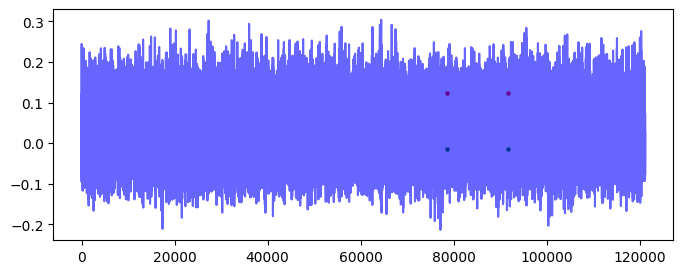

In [67]:
duplicate_group = 6019
plt.figure(figsize = (8,3))
plt.plot(df_normal.index, df_normal['DriveEndAcc'], color='blue', alpha=0.6)#DriveEnd Acc. is Blue
plt.scatter(df_normal[df_normal['duplicate_group']==duplicate_group].index, df_normal[df_normal['duplicate_group']==duplicate_group]['DriveEndAcc'], color='red', s=5)#Duplicates are red
plt.scatter(df_normal[df_normal['duplicate_group']==duplicate_group].index, df_normal[df_normal['duplicate_group']==duplicate_group]['FanEndAcc'], color='green', s=5)#Duplicates are red
plt.show()

In [26]:
df_normal

,FanEndAcc,DriveEndAcc,fault,duplicated
0,0.064254,0.038625,0,0
1,0.063002,0.096769,0,0
2,-0.004381,0.127382,0,0
3,-0.035882,0.144640,0,0
4,-0.023991,0.086702,0,0
...,...,...,...,...
121150,-0.034630,0.025065,0,0
121151,-0.047147,-0.010684,0,0
121152,-0.027954,-0.034927,0,0
121153,-0.010014,-0.046022,0,0


IR07 fault

In [33]:
df_ir07 = pd.read_csv(data02_path)
df_ir07.columns = signal_columns
df_ir07['fault'] = 1

In [34]:
df_ir21 = pd.read_csv(data03_path)
df_ir21.columns = signal_columns
df_ir21['fault'] = 2

In [35]:
df_or07 = pd.read_csv(data04_path)
df_or07.columns = signal_columns
df_or07['fault'] = 3

In [36]:
df_or21 = pd.read_csv(data03_path)
df_or21.columns = signal_columns
df_or21['fault'] = 4

In [ ]:
dataset = pd.concat([df_normal, df_ir07, df_ir21, df_or07, df_or21], ignore_index=True)